In [1]:
import pandas as pd
import numpy as np
import gurobipy as grb
from itertools import combinations
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# filepath = r"E:\2024 Fall Academic\Optimization Models and Methods\IEOR4004_Project2\airports.csv"
airports_df = pd.read_csv("airports.csv")
airports_df = airports_df.drop(columns=['Unnamed: 0']) #drop the original index
airports_df = airports_df.set_index('airport_code')
airports_df.head()

,country,airport_name,latitude,longitude,latitude_deg,longitude_deg
airport_code,,,,,,
JFK,USA,John F. Kennedy International Airport,40.639751°N,73.778925°W,40.639751,-73.778925
LAX,USA,Los Angeles International Airport,33.942536°N,118.408075°W,33.942536,-118.408075
ABJ,Côte d'Ivoire,Félix Houphouët Boigny International Airport,5.261417°N,3.925778°W,5.261417,-3.925778
SGN,Vietnam,Tan Son Nhat International Airport,10.818797°N,106.651856°E,10.818797,106.651856
LOS,Nigeria,Murtala Muhammed International Airport,6.577369°N,3.321156°E,6.577369,3.321156


In [3]:
#Calculte the distance matrices and create the dataframe
airport_codes = airports_df.index.tolist()

#Create the null datadrame
n = len(airport_codes)
distance_matrix_df = pd.DataFrame(
    data=[[0]*n for _ in range(n)],  # Initialize with zeros or any default value
    index=airport_codes,  # Row labels
    columns=airport_codes, # Column labels
    dtype = float
)

# Earth's radius in kilometers
R = 6371 

# Haversine formula function
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calculate the differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Apply the Haversine formula
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # Return the distance

# Calculate pairwise distances
for i in airport_codes:
    for j in airport_codes:
        if i != j:  # Exclude the same airport (distance to itself)
            dist = haversine(
                airports_df.loc[i, 'latitude_deg'],
                airports_df.loc[i, 'longitude_deg'],
                airports_df.loc[j, 'latitude_deg'],
                airports_df.loc[j, 'longitude_deg']
            )
            distance_matrix_df.loc[i,j]=dist

distance_matrix_df.head()

,JFK,LAX,ABJ,SGN,LOS,LUN,DAR,KGL,PAP,HRE,...,KRT,BKO,GUA,LFW,KBL,ROB,OUA,CKY,TIP,BZE
JFK,0.000000,3974.199962,7932.445338,14292.985735,8444.433260,12131.540012,12436.913035,11321.564031,2457.096611,12531.082351,...,10201.892576,7071.942699,3320.742820,8300.223022,10834.702090,7328.032681,7626.340835,6813.588504,7485.275620,2921.668991
LAX,3974.199962,0.000000,11889.687339,13130.434231,12418.516006,16105.679750,16227.358769,15188.259583,4858.775364,16504.654999,...,13706.897513,11043.455234,3531.499861,12273.503697,12356.043086,11256.835565,11598.556142,10748.343709,11044.420574,3502.779599
ABJ,7932.445338,11889.687339,0.000000,12126.944839,814.749463,4237.909109,4972.815263,3868.202352,7543.453633,4626.965032,...,4143.341574,921.426718,9495.948931,581.903836,8133.811652,720.294920,831.907983,1170.621886,3524.986505,9237.462726
SGN,14292.985735,13130.434231,12126.944839,0.000000,11313.043117,9086.282000,7719.302576,8577.983776,16744.101212,8885.163278,...,8001.758553,12343.071362,16614.619959,11545.906441,4616.972357,12790.960763,11676.366162,13030.605375,9682.939776,16459.320758
LOS,8444.433260,12418.516006,814.749463,11313.043117,0.000000,3687.902467,4252.500718,3124.810548,8262.738318,4088.871310,...,3338.756991,1401.592385,10234.972169,232.924648,7391.753467,1512.502886,832.630398,1893.444356,3074.065004,9959.216612


In [4]:
#Cteate the distance matrices dictionary
distance_array = distance_matrix_df.to_numpy()
distance_dict = {}
for i in range(len(airport_codes)):
    for j in range(len(airport_codes)):
            distance_dict [(airport_codes[i], airport_codes[j])] = distance_array[i,j]

## Problem 1: The Problem of Optimizing Shipment

In [5]:
model_pb1 = grb.Model("Problem 1")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-09


In [6]:
#Define the binary variable x between each pair of airports to decide whether the arcs between exists
x_vars = model_pb1.addVars(
    airport_codes,
    airport_codes,
    lb=0,             
    vtype=grb.GRB.BINARY,  
    name="x"          
)

In [7]:
#Each node is arrived and departed only once (except the starting and the ending point)
for i in airport_codes:
    departure_sum = grb.quicksum(x_vars[(i,j)] for j in airport_codes if i != j)
    arrival_sum = grb.quicksum(x_vars[(j,i)] for j in airport_codes if i != j)
    
    if i == "JFK":
        model_pb1.addConstr(departure_sum == 1, name = "JFK: departed only once")
        model_pb1.addConstr(arrival_sum == 0, name = "JFK: never arrived")
    elif i == "LAX":
        model_pb1.addConstr(departure_sum == 0, name = "LAX: never departed")
        model_pb1.addConstr(arrival_sum == 1, name = "LAX: arrived only once")
    else:
        model_pb1.addConstr(departure_sum == 1, name = "departed only once")
        model_pb1.addConstr(arrival_sum == 1, name = "arrived only once")

# Route x_ii == 0
for i in airport_codes:
    model_pb1.addConstr((x_vars[(i,i)]) == 0) 

In [8]:
#Set objective
total_distance = grb.quicksum((x_vars[(i,j)] * distance_dict[i,j]) 
                     for i in airport_codes
                     for j in airport_codes 
                    )
model_pb1.setObjective(total_distance, grb.GRB.MINIMIZE)
model_pb1.update()

In [9]:
print(f"Number of constraints: {len(model_pb1.getConstrs())}")
print(f"Number of variables: {len(model_pb1.getVars())}")

Number of constraints: 135
Number of variables: 2025


In [10]:
# Initially optimize the model
model_pb1.optimize()

# Define a function to detect subtours
def find_subtours(solution, n_nodes, airport_codes=airport_codes):
    """
    Detect subtours in the solution.
    solution: The current solution used to construct the path graph.
    Returns: A list of subtours, where each subtour is a set of nodes.
    """
    # Build an adjacency list
    graph = defaultdict(list)
    for i in airport_codes:
        for j in airport_codes:
            if solution[i, j] > 0.5:  # Selected paths
                graph[i].append(j)

    # Use Depth First Search (DFS) to find all connected components
    visited = {code: False for code in airport_codes}
    subtours = []

    def dfs(node, current_tour):
        visited[node] = True
        current_tour.append(node)
        for neighbor in graph[node]:
            if not visited[neighbor]:
                dfs(neighbor, current_tour)

    for airport in airport_codes:
        if not visited[airport]:
            current_tour = []
            dfs(airport, current_tour)
            if 2 <= len(current_tour) <= n_nodes - 1:  # Exclude single-node loops and the whole tour
                subtours.append(current_tour)

    return subtours

# Dynamically add subtour elimination constraints
while True:
    # Get the current solution
    solution = model_pb1.getAttr("X", x_vars)

    # Check if there are any subtours
    subtours = find_subtours(solution, n)

    # Termination condition 1: No subtours, optimal solution found
    if not subtours:
        print("Optimal solution found")
        break

    # Add subtour elimination constraints
    for subtour in subtours:
        # Construct subtour constraints
        if len(subtour) > 1:
            model_pb1.addConstr(
                grb.quicksum(
                    x_vars[i, j]
                    for i in subtour for j in subtour if i != j
                ) <= len(subtour) - 1
            )

    # Re-optimize the model
    model_pb1.optimize()

# Output the final path
if model_pb1.status == grb.GRB.OPTIMAL:
    print("Optimal path:")
    for i in airport_codes:
        for j in airport_codes:
            if x_vars[i, j].x > 0.5:
                print(f"Airport {i} -> Airport {j}")
    
    print(f"The minimum distance is {model_pb1.ObjVal:.2f}")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 135 rows, 2025 columns and 4005 nonzeros
Model fingerprint: 0x07f90622
Variable types: 0 continuous, 2025 integer (2025 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 256918.00481
Presolve removed 47 rows and 132 columns
Presolve time: 0.01s
Presolved: 88 rows, 1893 columns, 3786 nonzeros
Variable types: 0 continuous, 1893 integer (1893 binary)

Root relaxation: objective 3.907571e+04, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Ti

Optimal path:
JFK -> TIP, TIP -> BEY, BEY -> KBL, KBL -> ISB, ISB -> FRU, FRU -> ALA, ALA -> SGN, SGN -> ADD, ADD -> KRT, KRT -> JUB, JUB -> EBB, EBB -> KGL, KGL -> BJM, BJM -> NBO, NBO -> DAR, DAR -> LLW, LLW -> LUN, LUN -> HRE, HRE -> MPM, MPM -> SHO, SHO -> MSU, MSU -> JNB, JNB -> GBE, GBE -> WDH, WDH -> LAD, LAD -> FIH, FIH -> DLA, DLA -> LOS, LOS -> COO, COO -> LFW, LFW -> ACC, ACC -> ABJ, ABJ -> OUA, OUA -> BKO, BKO -> ROB, ROB -> FNA, FNA -> CKY, CKY -> DSS, DSS -> GEO, GEO -> JBQ, JBQ -> PAP, PAP -> BZE, BZE -> GUA, GUA -> LAX


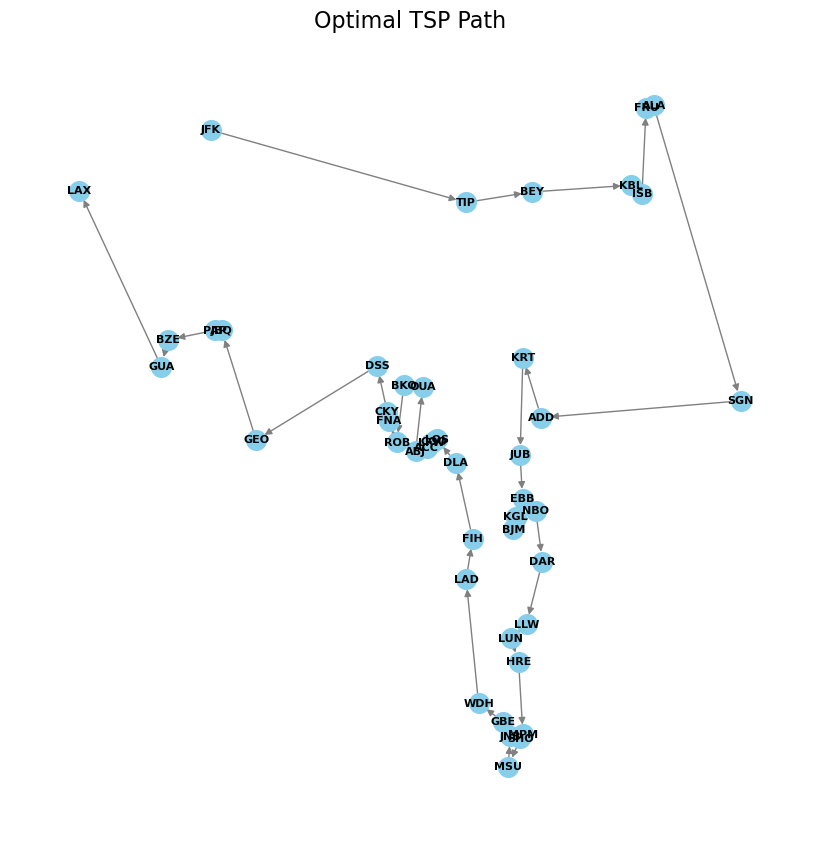

In [11]:
# Output the final path and plot the graph
if model_pb1.status == grb.GRB.OPTIMAL:
    print("Optimal path:")

    # Collect the optimal path
    optimal_path = {}
    for i in airport_codes:
        for j in airport_codes:
            if x_vars[i, j].x > 0.5:  # If the path is selected in the optimal solution
                optimal_path[i] = j

    # Output the ordered path
    start = "JFK"  # Assume the starting point is JFK; adjust as needed
    ordered_path = []
    current = start
    while current in optimal_path:
        next_node = optimal_path[current]
        ordered_path.append(f"{current} -> {next_node}")
        current = next_node
        if current == start:  # Stop when the path returns to the starting point
            break

    # Print the ordered path
    ordered_path_str = ", ".join(ordered_path)
    print(ordered_path_str)

    # Use NetworkX to draw the path graph
    G = nx.DiGraph()  # Create a directed graph
    for i in airport_codes:
        G.add_node(i, pos=(airports_df.loc[i, 'longitude_deg'], airports_df.loc[i, 'latitude_deg']))
    G.add_edges_from([(i, j) for i, j in optimal_path.items()])

    # Use circular layout for visualization
    # pos = nx.circular_layout(G)
    pos = nx.get_node_attributes(G, 'pos')

    # Plot the graph
    plt.figure(figsize=(8, 8))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="skyblue",
        edge_color="gray",
        node_size=200,
        font_size=8,
        font_weight="bold",
        arrowsize=10,  # Arrow size
    )
    plt.title("Optimal TSP Path", fontsize=16)
    plt.show()


In [12]:
#Check if every node is visited once
def time_check(airport):
    count = ordered_path_str.count(airport)
    if airport == "JFK" or airport == "LAX":
        if count == 1:
            return True
    else:
        if count ==2:
            return True

if all(time_check(i) for i in airport_codes):
    print('Every node is visited once!')

Every node is visited once!


In [13]:
#Check if there is subtours
if model_pb1.status == grb.GRB.OPTIMAL:
    solution = model_pb1.getAttr("X", x_vars)
    if not find_subtours(solution, n):
        print("No subtour found!")


No subtour found!


# Problem 2: The Problem of Optimizing Splitted Shipment

## Optimization based on limiting the number of nodes visited for one of the tours

In [14]:
# Create a subset of the airports by choosing first 10 airports
airports_df_part = airports_df.iloc[:15]
airport_codes_part = airports_df_part.index.tolist()
n_part = len(airport_codes_part)

In [15]:
dist_matrix_part = distance_matrix_df.loc[airport_codes_part, airport_codes_part]

In [16]:
distance_array_part = dist_matrix_part.to_numpy()
distance_dict_part = {}
for i in range(n_part):
    for j in range(n_part):
            distance_dict_part[(airport_codes_part[i], airport_codes_part[j])] = distance_array_part[i,j]

In [17]:
# Write a function that performs mTSP with 2 planes, where the first plane visits n1 airports among n airports
def mTSP_2planes(airport_codes, distance_dict, n1, plot_graph=False, MIPGap_in_elimination=0.05, MIPGap_final=0.0001): 
    
    n = len(airport_codes)
    n2 = n - n1
    
    mTSP = grb.Model("mTSP_2planes")
    
    # Add decision variable for plane 1 starting from JFK
    x1_vars = mTSP.addVars(
        airport_codes,
        airport_codes,
        lb=0,             
        vtype=grb.GRB.BINARY,  
        name="plane1"          
    )

    # Add decision variable for plane 2 starting from LAX
    x2_vars = mTSP.addVars(
        airport_codes,
        airport_codes,
        lb=0,             
        vtype=grb.GRB.BINARY,  
        name="plane2"          
    )
    
    #Each node is arrived and departed only once 
    for i in airport_codes:
        departure_sum = grb.quicksum(x1_vars[(i,j)] + x2_vars[(i,j)] for j in airport_codes if i != j)
        arrival_sum = grb.quicksum(x1_vars[(j,i)] + x2_vars[(j,i)] for j in airport_codes if i != j)

        mTSP.addConstr(departure_sum == 1, name = "departed only once")
        mTSP.addConstr(arrival_sum == 1, name = "arrived only once")

    # If one plane goes into an airport, it must leave the airport
    for i in airport_codes:
        mTSP.addConstr(grb.quicksum(x1_vars[(i,j)] for j in airport_codes) == grb.quicksum(x1_vars[(j,i)] for j in airport_codes))
        mTSP.addConstr(grb.quicksum(x2_vars[(i,j)] for j in airport_codes) == grb.quicksum(x2_vars[(j,i)] for j in airport_codes))

    # Route x_ii == 0
    for i in airport_codes:
        mTSP.addConstr((x1_vars[(i,i)]) == 0) 
        mTSP.addConstr((x2_vars[(i,i)]) == 0) 
        
    # Plane 1 must start and end at JFK
    mTSP.addConstr(grb.quicksum(x1_vars[("JFK", j)] for j in airport_codes if j != "JFK") == 1, name = "Plane 1 start at JFK")
    mTSP.addConstr(grb.quicksum(x1_vars[(i, "JFK")] for i in airport_codes if i != "JFK") == 1, name = "Plane 1 end at JFK")

    # Plane 2 must start and end at LAX
    mTSP.addConstr(grb.quicksum(x2_vars[("LAX", j)] for j in airport_codes if j != "LAX") == 1, name = "Plane 2 start at LAX")
    mTSP.addConstr(grb.quicksum(x2_vars[(i, "LAX")] for i in airport_codes if i != "LAX") == 1, name = "Plane 2 end at LAX")

    # Plane 1 should visit n1 airports
    mTSP.addConstr(grb.quicksum(x1_vars[(i, j)] for i in airport_codes for j in airport_codes) == n1, name = "Plane 1 visit n1 airports")

    # Plane 2 should visit n2 airports
    mTSP.addConstr(grb.quicksum(x2_vars[(i, j)] for i in airport_codes for j in airport_codes) == n2, name = "Plane 2 visit n2 airports")
    
    #Set objective
    plane1_distance = grb.quicksum((x1_vars[(i,j)] * distance_dict[(i,j)]) 
                        for i in airport_codes
                        for j in airport_codes 
                        )

    plane2_distance = grb.quicksum((x2_vars[(i,j)] * distance_dict[(i,j)]) 
                        for i in airport_codes
                        for j in airport_codes 
                        )

    total_distance = plane1_distance + plane2_distance
    mTSP.setObjective(total_distance, grb.GRB.MINIMIZE)
    mTSP.update()
    
    # Initially optimize the model
    mTSP.optimize()

    # Dynamically add subtour elimination constraints
    iteration_count = 0
    iteration_limit = 200

    while True:
        
        if iteration_count > iteration_limit:
            print("Terminated due to the maximum number of iterations")
            break
        
        # Get the current solution
        palne1_sol = mTSP.getAttr("X", x1_vars)
        plane2_sol = mTSP.getAttr("X", x2_vars)
        
        # Check if there are any subtours
        plane1_subtours = find_subtours(palne1_sol, n1, airport_codes)
        plane2_subtours = find_subtours(plane2_sol, n2, airport_codes)
        
        # Termination condition 1: No subtours, optimal solution found
        if not plane1_subtours and not plane2_subtours:
            print("Optimal solution found")
            break
        
        # Add subtour elimination constraints
        if plane1_subtours:
            for subtour in plane1_subtours:
                # Construct subtour constraints
                if len(subtour) > 1:
                    mTSP.addConstr(
                        grb.quicksum(
                            x1_vars[i, j]
                            for i in subtour for j in subtour if i != j
                        ) <= len(subtour) - 1
                    )
                    
        if plane2_subtours:
            for subtour in plane2_subtours:
                # Construct subtour constraints
                if len(subtour) > 1:
                    mTSP.addConstr(
                        grb.quicksum(
                            x2_vars[i, j]
                            for i in subtour for j in subtour if i != j
                        ) <= len(subtour) - 1
                    )
                    
        iteration_count += 1
        
        # Re-optimize the model
        mTSP.setParam('MIPGap', MIPGap_in_elimination)
        mTSP.optimize()

    # Optimize again with lower MIPGap
    # mTSP.setParam('MIPGap', MIPGap_final)
    # mTSP.optimize()
    
    if plot_graph == True:
        # Collect the optimal path
        plane1_path = {}
        for i in airport_codes:
            for j in airport_codes:
                if x1_vars[i, j].x > 0.5:  # If the path is selected in the optimal solution
                    plane1_path[i] = j
                    
        plane2_path = {}
        for i in airport_codes:
            for j in airport_codes:
                if x2_vars[i, j].x > 0.5:  # If the path is selected in the optimal solution
                    plane2_path[i] = j
                    
        # Use NetworkX to draw the path graph
        G2 = nx.DiGraph()  # Create a directed graph
        for i in airport_codes:
            G2.add_node(i, pos=(airports_df.loc[i, 'longitude_deg'], airports_df.loc[i, 'latitude_deg']))
        G2.add_edges_from([(i, j) for i, j in plane1_path.items()])
        for i, j in plane1_path.items():
            G2[i][j]['color'] = 'blue'
        G2.add_edges_from([(i, j) for i, j in plane2_path.items()])
        for i, j in plane2_path.items():
            G2[i][j]['color'] = 'red'
            
        edge_colors = [G2[u][v]['color'] for u, v in G2.edges()]

        pos = nx.get_node_attributes(G2, 'pos')

        # Plot the graph
        plt.figure(figsize=(8, 8))
        nx.draw(
            G2,
            pos,
            with_labels=True,
            node_color="skyblue",
            node_size=200,
            font_size=8,
            font_weight="bold",
            arrowsize=10,  # Arrow size
            edge_color=edge_colors
        )
        plt.title("Optimal mTSP Path", fontsize=16)
        plt.show()
        
        optimal_distance = mTSP.ObjVal
        
        return optimal_distance, plane1_path, plane2_path

## mTSP to TSP

The two salesman problem is solved by transforming it into one traveling salesman problem. The transformation is based on https://doi.org/10.1016/0377-2217(94)00011-Z. 

In [18]:
airport_codes_transformed = airport_codes + ["JFK_i", "LAX_i"]

distance_matrix_df_transformed = distance_matrix_df.copy()
distance_matrix_df_transformed["JFK_i"] = distance_matrix_df_transformed["JFK"]
distance_matrix_df_transformed["LAX_i"] = distance_matrix_df_transformed["LAX"]
distance_matrix_df_transformed.loc["JFK_i"] = distance_matrix_df_transformed.loc["JFK"]
distance_matrix_df_transformed.loc["LAX_i"] = distance_matrix_df_transformed.loc["LAX"]

# Distance from imaginary to next imaginary is 0
distance_matrix_df_transformed["JFK_i"]["LAX_i"] = 0

# Distance from imaginary to next depot is 0
distance_matrix_df_transformed["JFK_i"]["LAX"] = 0

# Distance from last imaginary to the first depot is 0
distance_matrix_df_transformed["LAX_i"]["JFK"] = 0

In [19]:
imaginary_edge_list = [("JFK_i", "LAX_i"), ("JFK_i", "LAX"), ("LAX_i", "JFK")]

In [20]:
distance_dict_transformed = distance_matrix_df_transformed.to_dict()

In [21]:
depot_nodes = ["JFK", "LAX"]
customer_nodes = [node for node in airport_codes if node not in depot_nodes]
imaginary_nodes = [f"{depot}_i" for depot in depot_nodes]

edge_list = []
# Add all edges between customers
for i in customer_nodes:
    for j in customer_nodes:
        if i != j:
            edge_list.append((i, j))

# Add all edges between depots and customers (in both directions)
for i in depot_nodes:
    for j in customer_nodes:
        edge_list.append((i, j))
        edge_list.append((j, i))
        
# Add all edges from customers to imaginary nodes
for i in customer_nodes:
    for j in imaginary_nodes:
        edge_list.append((i, j))

# Add edge from imaginary node to the next imaginary node
edge_list.append(("JFK_i", "LAX_i"))

# Add edge from imaginary node to the next depot
edge_list.append(("JFK_i", "LAX"))

# Add edge from last imaginary node to the first depot
edge_list.append(("LAX_i", "JFK"))

In [22]:
# Convert the edge list to a dictionary 
edges_out_dict = defaultdict(list)
edges_in_dict = defaultdict(list)
for i, j in edge_list:
    edges_out_dict[i].append(j)
    edges_in_dict[j].append(i)

In [23]:
nodes_list = list(edges_out_dict.keys())

In [24]:
# def solve_transformed_TSP(depot_nodes, customer_nodes, imaginary_nodes, edge_list, distance_dict):
TSP = grb.Model("TSP")

#Define the binary variable x between each pair of airports to decide whether the arcs between exists
x_vars = TSP.addVars(
    edge_list,
    lb=0,             
    vtype=grb.GRB.BINARY,  
    name="x"          
)

#Each node is arrived and departed only once
for i in edges_out_dict:
    departure_sum = grb.quicksum(x_vars[(i,j)] for j in edges_out_dict[i])
    TSP.addConstr(departure_sum == 1, name = "departed only once")
    
for i in edges_in_dict:
    arrival_sum = grb.quicksum(x_vars[(j,i)] for j in edges_in_dict[i])
    TSP.addConstr(arrival_sum == 1, name = "arrived only once")

#Set objective
total_distance = grb.quicksum((x_vars[(i,j)] * distance_matrix_df_transformed[i][j]) 
                    for i, j in edge_list
                    )
TSP.setObjective(total_distance, grb.GRB.MINIMIZE)
TSP.update()

# Initially optimize the model
TSP.optimize()

# Define a function to detect subtours
def find_subtours(solution, nodes_list):
    """
    Detect subtours in the solution.
    solution: The current solution used to construct the path graph.
    Returns: A list of subtours, where each subtour is a set of nodes.
    """
    n_nodes = len(nodes_list)
    
    # Build an adjacency list
    graph = defaultdict(list)
    for i, j in edge_list:
        if solution[i, j] > 0.5:  # Selected paths
            graph[i].append(j)

    # Use Depth First Search (DFS) to find all connected components
    visited = {code: False for code in nodes_list}
    subtours = []

    def dfs(node, current_tour):
        visited[node] = True
        current_tour.append(node)
        for neighbor in graph[node]:
            if not visited[neighbor]:
                dfs(neighbor, current_tour)

    for airport in nodes_list:
        if not visited[airport]:
            current_tour = []
            dfs(airport, current_tour)
            if 2 <= len(current_tour) <= n_nodes - 1:  # Exclude single-node loops and the whole tour
                subtours.append(current_tour)

    return subtours

# Dynamically add subtour elimination constraints
while True:
    # Get the current solution
    solution = TSP.getAttr("X", x_vars)

    # Check if there are any subtours
    subtours = find_subtours(solution, nodes_list)

    # Termination condition 1: No subtours, optimal solution found
    if not subtours:
        print("Optimal solution found")
        break

    # Add subtour elimination constraints
    for subtour in subtours:
        # Construct subtour constraints
        if len(subtour) > 1:
            TSP.addConstr(
                grb.quicksum(
                    x_vars[i, j]
                    for i in subtour 
                    for j in subtour 
                    if (i, j) in edge_list
                ) <= len(subtour) - 1
            )

    # Re-optimize the model
    TSP.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 94 rows, 2067 columns and 4134 nonzeros
Model fingerprint: 0x94c882ec
Variable types: 0 continuous, 2067 integer (2067 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 250704.03578
Presolve removed 4 rows and 89 columns
Presolve time: 0.01s
Presolved: 90 rows, 1978 columns, 3956 nonzeros
Variable types: 0 continuous, 1978 integer (1978 binary)

Root relaxation: objective 4.622124e+04, 70 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


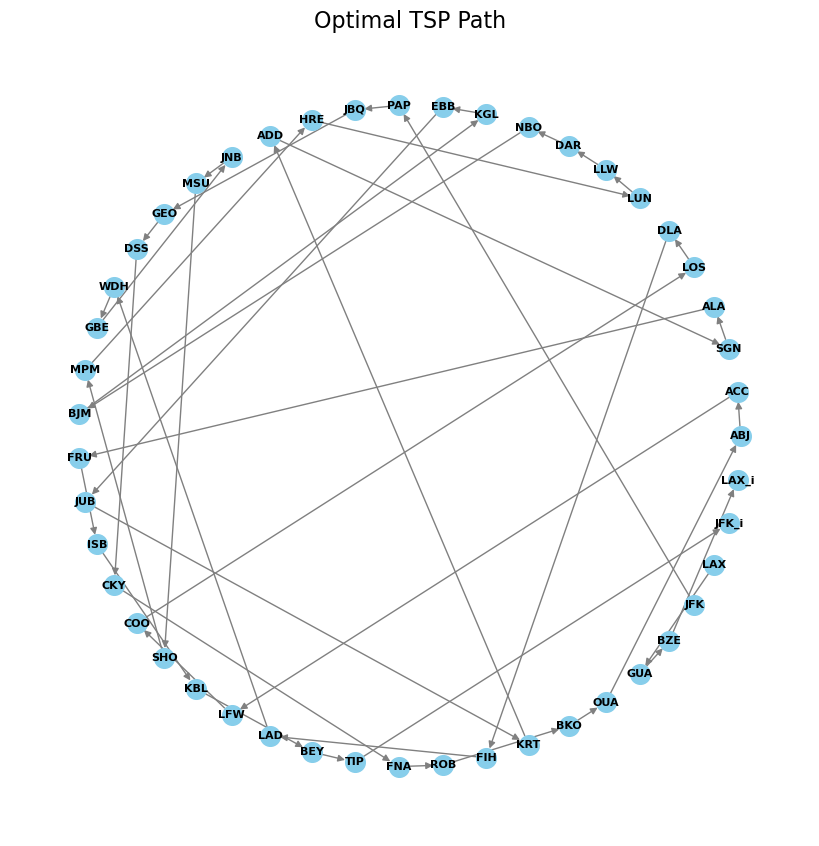

In [25]:
# Collect the optimal path
optimal_path = {}
for i, j in edge_list:
    if x_vars[i, j].x > 0.5:
        if (i, j) not in imaginary_edge_list:
            optimal_path[i] = j

# Use NetworkX to draw the path graph
G = nx.DiGraph()  # Create a directed graph
# for i in airport_codes_transformed:
#     G.add_node(i, pos=(airports_df_transformed.loc[i, 'longitude_deg'], airports_df_transformed.loc[i, 'latitude_deg']))
G.add_edges_from([(i, j) for i, j in optimal_path.items()])

# Use circular layout for visualization
pos = nx.circular_layout(G)

# Plot the graph
plt.figure(figsize=(8, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="skyblue",
    edge_color="gray",
    node_size=200,
    font_size=8,
    font_weight="bold",
    arrowsize=10,  # Arrow size
)
plt.title("Optimal TSP Path", fontsize=16)
plt.show()

In [26]:
# Contract imaginary nodes
M = nx.contracted_nodes(G, "LAX", "LAX_i", self_loops=False)
M = nx.contracted_nodes(M, "JFK", "JFK_i", self_loops=False)

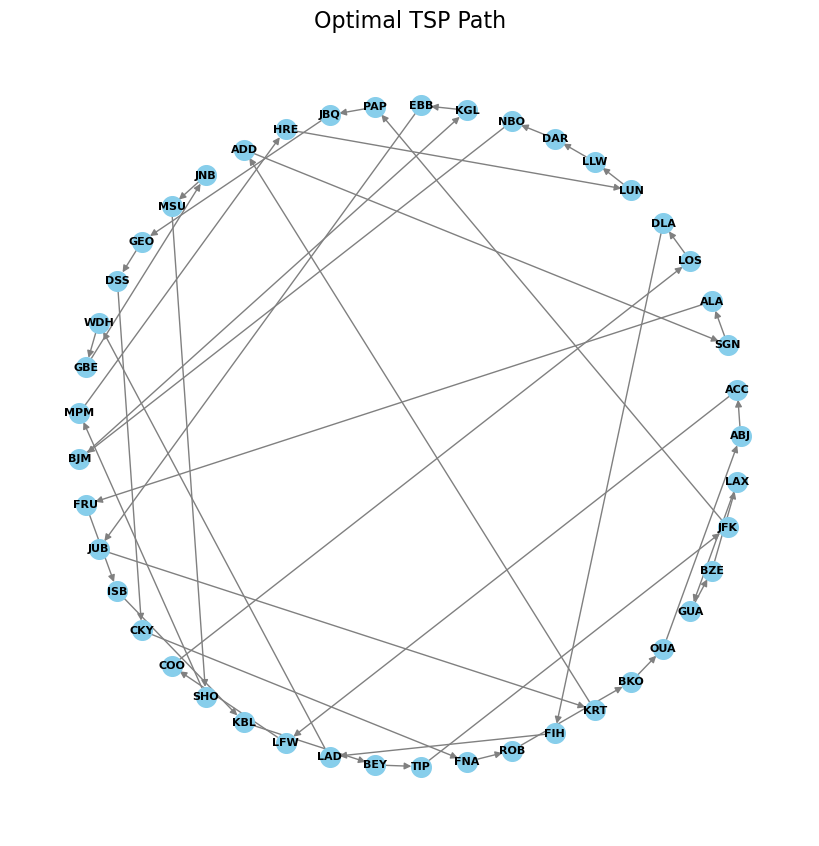

In [27]:
# Use circular layout for visualization
pos = nx.circular_layout(M)

# Plot the graph
plt.figure(figsize=(8, 8))
nx.draw(
    M,
    pos,
    with_labels=True,
    node_color="skyblue",
    edge_color="gray",
    node_size=200,
    font_size=8,
    font_weight="bold",
    arrowsize=10,  # Arrow size
)
plt.title("Optimal TSP Path", fontsize=16)
plt.show()

In [28]:
# Add positions to the graph
pos = defaultdict(tuple)

for i in airport_codes:
    pos[i] = (airports_df.loc[i, 'longitude_deg'], airports_df.loc[i, 'latitude_deg'])
    
nx.set_node_attributes(M, pos, "pos")

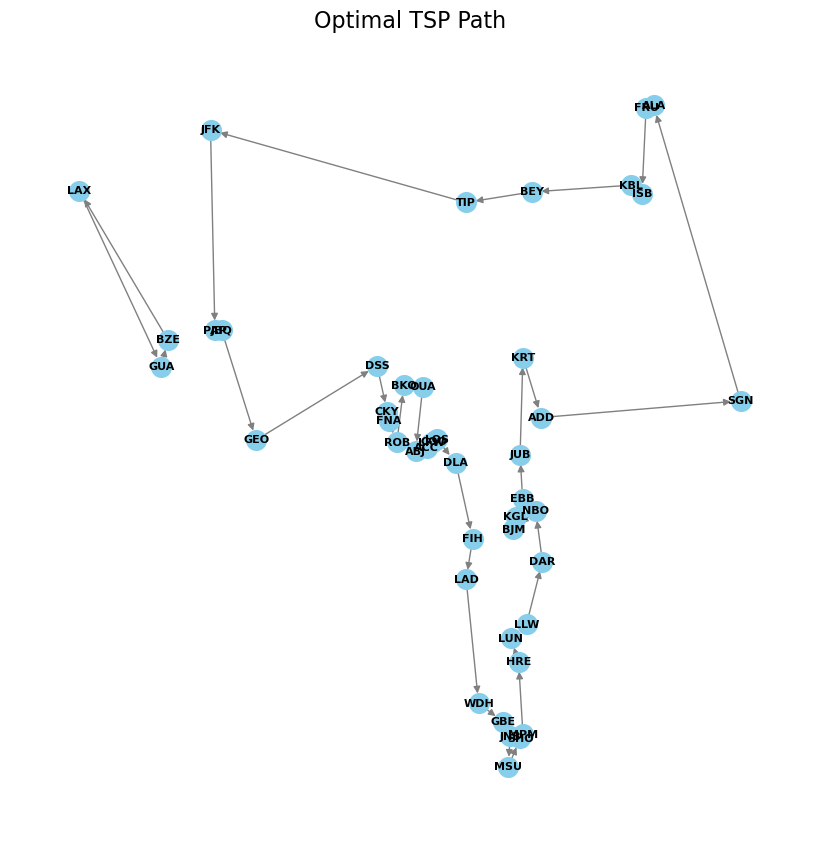

In [29]:
# Plot the graph
plt.figure(figsize=(8, 8))
nx.draw(
    M,
    pos,
    with_labels=True,
    node_color="skyblue",
    edge_color="gray",
    node_size=200,
    font_size=8,
    font_weight="bold",
    arrowsize=10,  # Arrow size
)
plt.title("Optimal TSP Path", fontsize=16)
plt.show()

In [30]:
# Find the connected components of M
connected_components = list(nx.weakly_connected_components(M))
print('Number of connected components: ', len(connected_components))

Number of connected components:  2
